In [42]:
!pip install keras_cv==0.5.0 wandb -q
!pip install -U keras-cv-attention-models -q
!pip install dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.6 MB/s eta 0:00:0000:010:01
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.17
    Uninstalling SQLAlchemy-2.0.17:
      Successfully uninstalled SQLAlchemy-2.0.17
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.52 which is incompatible.


# **<span style="color:#088567;">Import Packages </span>**

In [3]:
import os
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn import linear_model, model_selection


import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.python.client import device_lib

import keras_cv as kcv
from keras_cv import visualization
from keras_cv.models import ResNet18Backbone

from kaggle_secrets import UserSecretsClient
import wandb
from datetime import datetime

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:

user_secrets = UserSecretsClient()
wandb_api_key = os.getenv("WANDB_API_KEY")
wandb.login(key=wandb_api_key)


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
from wandb.keras import WandbCallback, WandbMetricsLogger
run = wandb.init(project = 'Machine_Unlearning_ACM',
                 save_code = True,
                 name='coatnet'
                 
)

wandb: Currently logged in as: vaibhavsatish (aicademia). Use `wandb login --relogin` to force relogin


# **<span style="color:#088567;">Device Configuration </span>**

In [6]:
def set_device(mixed_precision=True, set_jit=False):
    # printed out the detected devices
    list_ld = device_lib.list_local_devices()
    for dev in list_ld: 
        print(dev.name,dev.memory_limit)

    # get the lisf of physical devices
    physical_devices = tf.config.list_physical_devices(
        'GPU' if len(list_ld) - 1 else 'CPU'
    )
    # For GPU devices, configure related stuff
    if 'GPU' in physical_devices[-1]:
        tf.config.optimizer.set_jit(set_jit)
        if mixed_precision:
            keras.mixed_precision.set_global_policy(
                "mixed_float16"
            )
        else:
            keras.mixed_precision.set_global_policy(
                keras.backend.floatx()
            )
        for pd in physical_devices:
            tf.config.experimental.set_memory_growth(
                pd, True
            )
    strategy = tf.distribute.MirroredStrategy()
    return (strategy, physical_devices)

In [7]:
strategy, physical_devices = set_device(mixed_precision=True, set_jit=True)
physical_devices, strategy, tf.__version__

/device:CPU:0 268435456
/device:GPU:0 16274030592


([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')],
 '2.12.0')

# **<span style="color:#088567;">Data Pipeline </span>**

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 128

(x_train, y_train), held_out = keras.datasets.cifar10.load_data()
test_set, val_set = keras.utils.split_dataset(held_out, left_size=0.2)

170498071/170498071 [==============================] - 10s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/utils/dataset_utils.py:157: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(sample)


In [9]:
def normalize(image, label, denorm=False):
    rescale = keras.layers.Rescaling(scale=1./255.)
    norms = keras.layers.Normalization(
        mean=[0.4914, 0.4822, 0.4465], 
        variance=[np.square(0.2023), np.square(0.1994), np.square(0.2010)], 
        invert=denorm,
        axis=-1,
    )
    
    if not denorm:
        image = rescale(image)
    return norms(image), label


In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(normalize)
train_ds = train_ds.shuffle(buffer_size=8*BATCH_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = val_set.map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_set.map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)

(128, 32, 32, 3) (128, 1)


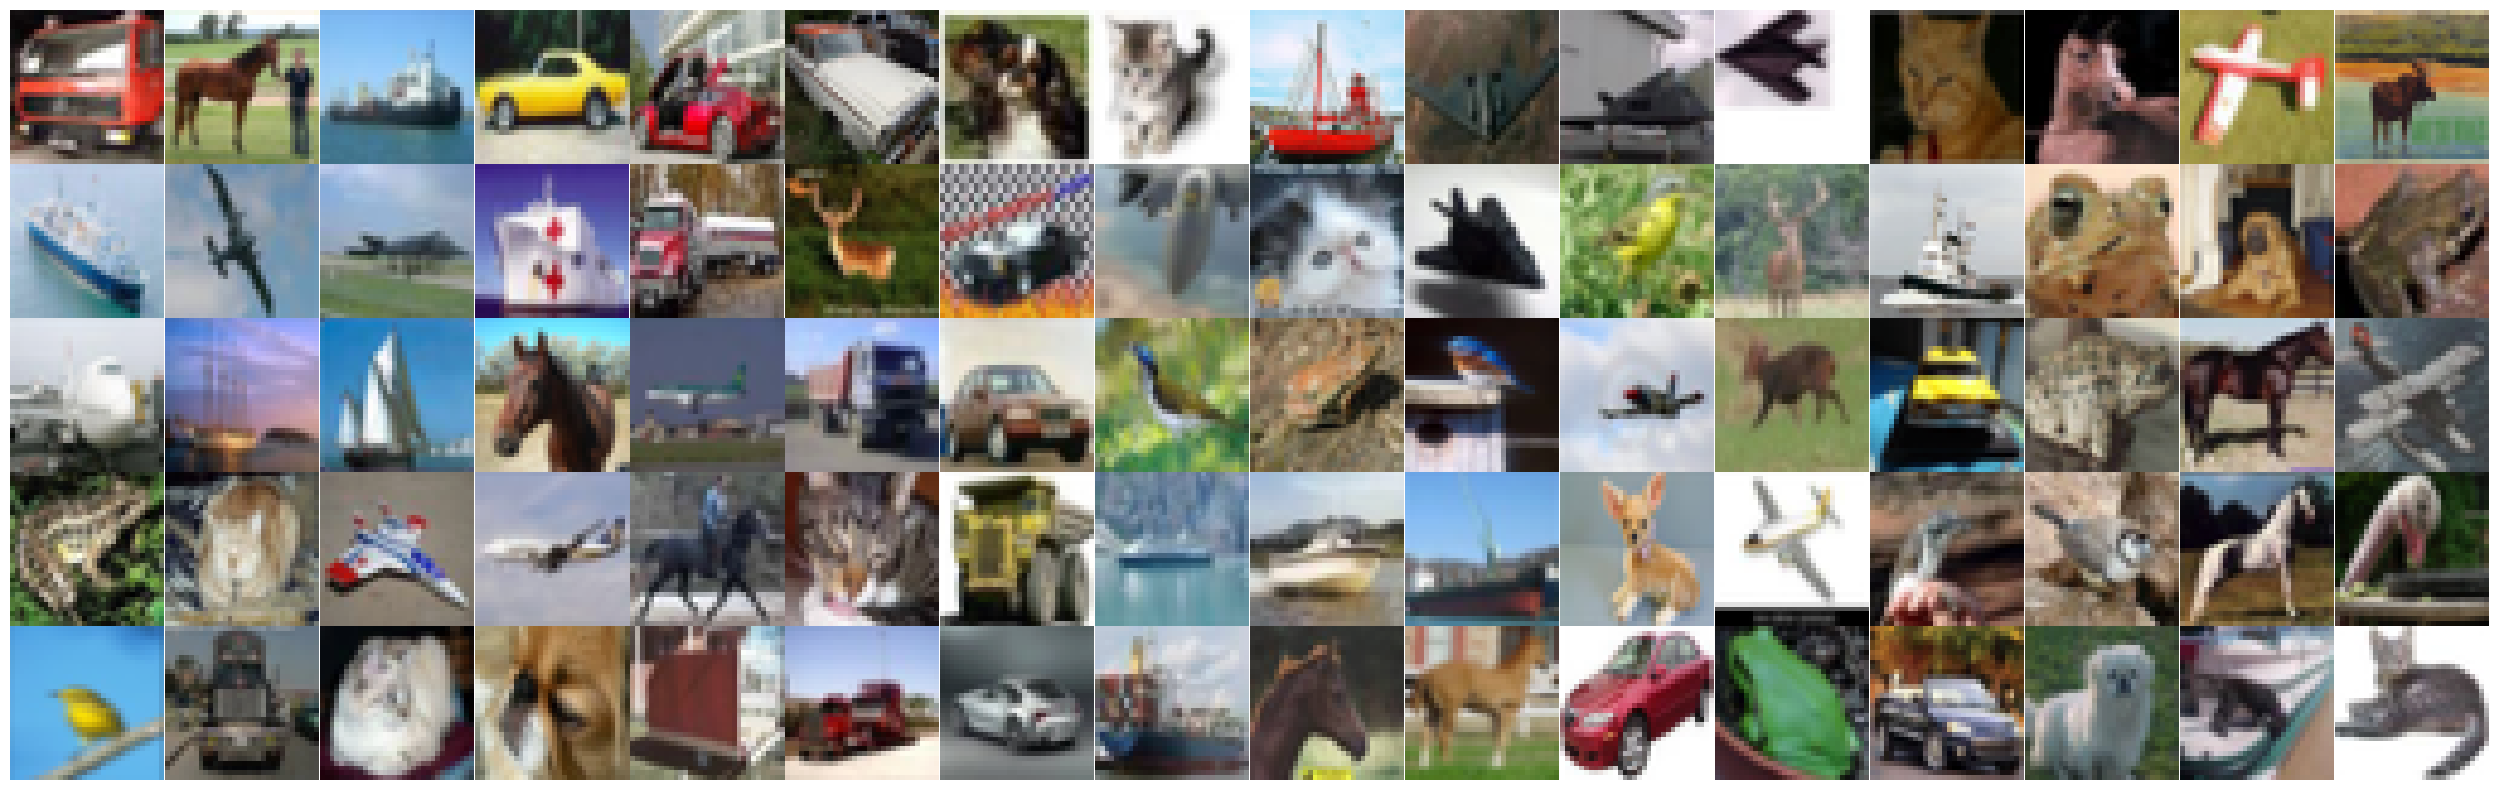

In [11]:
temp_ds = train_ds.map(lambda x,y:normalize(x,y, denorm=True))
images, labels = next(iter(temp_ds))
print(images.shape, labels.shape)

visualization.plot_image_gallery(
    images, value_range=(0, 1), rows=5, cols=16
)


# **<span style="color:#088567;">CoAtNet </span>**

CoAtNets are a family of hybrid models based on the following 
1. Depthwise convolution and self-attention can be naturally unified via simple relative attention

2. Vertically stacking convolution layers and attention layers in a principled way is surprisingly effective in improving generalization, capacity, and efficiency.


In [12]:
from keras_cv_attention_models import coatnet
def get_model():
    with strategy.scope():
        model = keras.Sequential(
            [
                coatnet.CoAtNet0(num_classes=0,input_shape=(32,32,3),pretrained=None),
                keras.layers.GlobalMaxPooling2D(),
                keras.layers.Dense(10, activation="softmax", dtype=tf.float32),
            ]
        )
        model.compile(
            optimizer='adam', 
            loss='sparse_categorical_crossentropy', 
            metrics=metrics.SparseCategoricalAccuracy(name='accuracy'),
            jit_compile=True
        )
    
    return model



In [13]:
model = get_model()
model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[WandbMetricsLogger()])
model.save("coat_cifat10.keras", save_format="keras_v3")

Epoch 1/20
391/391 [==============================] - 137s 201ms/step - loss: 3.6955 - accuracy: 0.4004 - val_loss: 1.2222 - val_accuracy: 0.5698
Epoch 2/20
391/391 [==============================] - 29s 74ms/step - loss: 1.0905 - accuracy: 0.6197 - val_loss: 1.2440 - val_accuracy: 0.6034
Epoch 3/20
391/391 [==============================] - 29s 74ms/step - loss: 0.8176 - accuracy: 0.7167 - val_loss: 0.8727 - val_accuracy: 0.7171
Epoch 4/20
391/391 [==============================] - 29s 73ms/step - loss: 0.6963 - accuracy: 0.7619 - val_loss: 0.9697 - val_accuracy: 0.6898
Epoch 5/20
391/391 [==============================] - 29s 74ms/step - loss: 0.5891 - accuracy: 0.7994 - val_loss: 0.8204 - val_accuracy: 0.7462
Epoch 6/20
391/391 [==============================] - 29s 73ms/step - loss: 0.4977 - accuracy: 0.8287 - val_loss: 0.7448 - val_accuracy: 0.7746
Epoch 7/20
391/391 [==============================] - 29s 74ms/step - loss: 0.4501 - accuracy: 0.8451 - val_loss: 1.0024 - val_accurac

In [14]:
print(f"Train set accuracy: {100.0 * model.evaluate(train_ds)[-1]:0.1f}%%")
print(f"Test set accuracy: {100.0 * model.evaluate(test_ds)[-1]:0.1f}%%")

391/391 [==============================] - 11s 26ms/step - loss: 0.1328 - accuracy: 0.9565
Train set accuracy: 95.7%%
16/16 [==============================] - 0s 14ms/step - loss: 1.1904 - accuracy: 0.7940
Test set accuracy: 79.4%%


# **<span style="color:#088567;">Unlearning By Retraining </span>**

In [15]:
forget_set, retain_set = keras.utils.split_dataset(train_ds.unbatch(), left_size=0.1)
forget_ds = forget_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
retain_ds = retain_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
int(forget_ds.cardinality()), int(retain_ds.cardinality())

(40, 352)

In [16]:
def unlearning(net, retain, forget, validation):

    epochs = 20
 
    with strategy.scope():
        # loss, metric, scheduler, optimizer
        loss = losses.SparseCategoricalCrossentropy()
        metric = metrics.SparseCategoricalAccuracy(name='accuracy')
        sched = optimizers.schedules.CosineDecay(
            initial_learning_rate=0.1, decay_steps=retain.cardinality() * epochs
        )
        optim = optimizers.SGD(
            learning_rate=sched, momentum=0.9, weight_decay=5e-4
        )
        
        # compile the model
        net.compile(
            optimizer=optim, 
            loss=loss, 
            metrics=metric,
        )

    # training
    net.fit(retain,verbose=1, epochs=epochs,callbacks=[WandbMetricsLogger()])
    
    return net


In [17]:
with strategy.scope():
    # load pre-trained model
    net = keras.models.load_model("/kaggle/working/coat_cifat10.keras")

# Execute the unlearing routine. This might take a few minutes.
# If run on colab, be sure to be running it on  an instance with GPUs
model_ft = unlearning(net, retain_ds, forget_ds, test_ds)

Epoch 1/5
352/352 [==============================] - 75s 75ms/step - loss: nan - accuracy: 0.1088
Epoch 2/5
352/352 [==============================] - 50s 143ms/step - loss: nan - accuracy: 0.0999
Epoch 3/5
352/352 [==============================] - 22s 62ms/step - loss: nan - accuracy: 0.0999
Epoch 4/5
352/352 [==============================] - 22s 62ms/step - loss: nan - accuracy: 0.0999
Epoch 5/5
352/352 [==============================] - 22s 62ms/step - loss: nan - accuracy: 0.0999


In [18]:
print(f"Retain set accuracy: {100.0 * model_ft.evaluate(retain_ds)[-1]:0.1f}%%")
print(f"Test set accuracy: {100.0 * model_ft.evaluate(test_ds)[-1]:0.1f}%%")

352/352 [==============================] - 12s 14ms/step - loss: nan - accuracy: 0.0998
Retain set accuracy: 10.0%%
16/16 [==============================] - 1s 50ms/step - loss: nan - accuracy: 0.1020
Test set accuracy: 10.2%%


In [19]:
run.finish()

wandb: WARNING Source type is set to 'artifact' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch/accuracy,▃▅▆▆▇▇▇▇▇▇██████████▁▁▁▁▁
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██▁▁▂▂▂
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████
epoch/loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▂▆▅▆▇▆██▇█▇██▇█████
epoch/val_loss,██▃▄▂▁▅▂▂▃▂▄▃▃▆▅▆▆▆▇
epoch/accuracy,0.09989
epoch/epoch,4
epoch/learning_rate,0.09999
epoch/loss,nan
epoch/val_accuracy,0.79338


# **<span style="color:#088567;">EfficientFormerV2 </span>**



In [20]:
from wandb.keras import WandbCallback, WandbMetricsLogger
run = wandb.init(project = 'Machine_Unlearning_ACM',
                 save_code = True,
                 name='EfficientFormerV2S'
                 
)

In [21]:
from keras_cv_attention_models import efficientformer
def get_model():
        model = keras.Sequential(
            [
                efficientformer.EfficientFormerV2S0(num_classes=0,input_shape=(32,32,3),pretrained=None),
                keras.layers.GlobalMaxPooling2D(),
                keras.layers.Dense(10, activation="softmax", dtype=tf.float32),
            ]
        )
        model.summary()
        model.compile(
            optimizer='adam', 
            loss='sparse_categorical_crossentropy', 
            metrics=metrics.SparseCategoricalAccuracy(name='accuracy'),
        )
    
        return model

model = get_model()
model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[WandbMetricsLogger()])
model.save("EfficientFormerV2S_cifat10.keras", save_format="keras_v3")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientformer_v2_s0 (Func  (None, 1, 1, 176)        3291792   
 tional)                                                         
                                                                 
 global_max_pooling2d_1 (Glo  (None, 176)              0         
 balMaxPooling2D)                                                
                                                                 
 dense_1 (Dense)             (None, 10)                1770      
                                                                 
Total params: 3,293,562
Trainable params: 3,244,602
Non-trainable params: 48,960
_________________________________________________________________
Epoch 1/20
391/391 [==============================] - 147s 141ms/step - loss: 1.4731 - accuracy: 0.4854 - val_loss: 1.1852 - val_accuracy: 0.5781
Epoch 2/20
391/391 [=====

In [22]:
print(f"Train set accuracy: {100.0 * model.evaluate(train_ds)[-1]:0.1f}%%")
print(f"Test set accuracy: {100.0 * model.evaluate(test_ds)[-1]:0.1f}%%")

391/391 [==============================] - 5s 14ms/step - loss: 0.0845 - accuracy: 0.9702
Train set accuracy: 97.0%%
16/16 [==============================] - 6s 394ms/step - loss: 1.6340 - accuracy: 0.7125
Test set accuracy: 71.2%%


In [23]:
forget_set, retain_set = keras.utils.split_dataset(train_ds.unbatch(), left_size=0.1)
forget_ds = forget_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
retain_ds = retain_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [24]:
int(forget_ds.cardinality()), int(retain_ds.cardinality())

def unlearning(net, retain, forget, validation):

        epochs = 20
 
        # loss, metric, scheduler, optimizer
        loss = losses.SparseCategoricalCrossentropy()
        metric = metrics.SparseCategoricalAccuracy(name='accuracy')
        sched = optimizers.schedules.CosineDecay(
            initial_learning_rate=0.1, decay_steps=retain.cardinality() * epochs
        )
        optim = optimizers.SGD(
            learning_rate=sched, momentum=0.9, weight_decay=5e-4
        )
        
        # compile the model
        net.compile(
            optimizer=optim, 
            loss=loss, 
            metrics=metric,
        )

    # training
        net.fit(retain, epochs=epochs,callbacks=[WandbMetricsLogger()])
    
        return net

In [25]:
# load pre-trained model
net = keras.models.load_model("EfficientFormerV2S_cifat10.keras")

# Execute the unlearing routine. This might take a few minutes.
# If run on colab, be sure to be running it on  an instance with GPUs
model_ft = unlearning(net, retain_ds, forget_ds, test_ds)

Epoch 1/5
352/352 [==============================] - 129s 87ms/step - loss: 1.4418 - accuracy: 0.4998
Epoch 2/5
352/352 [==============================] - 75s 212ms/step - loss: 0.9072 - accuracy: 0.6783
Epoch 3/5
352/352 [==============================] - 27s 76ms/step - loss: 0.6082 - accuracy: 0.7852
Epoch 4/5
352/352 [==============================] - 27s 76ms/step - loss: 0.3679 - accuracy: 0.8699
Epoch 5/5
352/352 [==============================] - 27s 75ms/step - loss: 0.1830 - accuracy: 0.9407


In [26]:
print(f"Retain set accuracy: {100.0 * model_ft.evaluate(retain_ds)[-1]:0.1f}%%")
print(f"Test set accuracy: {100.0 * model_ft.evaluate(test_ds)[-1]:0.1f}%%")

352/352 [==============================] - 13s 13ms/step - loss: 0.1427 - accuracy: 0.9550
Retain set accuracy: 95.5%%
16/16 [==============================] - 0s 14ms/step - loss: 1.1296 - accuracy: 0.7315
Test set accuracy: 73.2%%


In [27]:
run.finish()

wandb: WARNING Source type is set to 'artifact' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch/accuracy,▁▃▄▅▅▆▆▆▇▇▇▇████████▁▄▅▇█
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██▁▁▂▂▂
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▆▄▂▁
epoch/loss,█▆▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁█▅▄▂▂
epoch/val_accuracy,▁▄▆▇▇▇▇▇▇▇▇▇██▇█████
epoch/val_loss,▄▂▁▁▁▁▂▃▃▄▅▆▅▆▇▆▇▇▇█
epoch/accuracy,0.94071
epoch/epoch,4
epoch/learning_rate,0.0
epoch/loss,0.18301
epoch/val_accuracy,0.7155


# **<span style="color:#088567;">ResNet-18 </span>**



In [28]:
from wandb.keras import WandbCallback, WandbMetricsLogger
run = wandb.init(project = 'Machine_Unlearning_ACM',
                 save_code = True,
                 name='ResNet-18'
                 
)

In [29]:
from keras.applications import resnet, ResNet18 

def get_model():
    base_model = ResNet18(weights=None, include_top=False, input_shape=(32, 32, 3))
    model = keras.Sequential(
        [
            base_model,
            layers.GlobalMaxPooling2D(),
            layers.Dense(10, activation="softmax", dtype=tf.float32),
        ]
    )
    model.summary()
    model.compile(
        optimizer='adam', 
        loss='sparse_categorical_crossentropy', 
        metrics=[metrics.SparseCategoricalAccuracy(name='accuracy')],
    )
    return model

model = get_model()
model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[WandbMetricsLogger()])
model.save("ResNet18_cifar10.keras", save_format="keras_v3")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientformer_v2_s0 (Func  (None, 1, 1, 176)        3291792   
 tional)                                                         
                                                                 
 global_max_pooling2d_2 (Glo  (None, 176)              0         
 balMaxPooling2D)                                                
                                                                 
 dense_2 (Dense)             (None, 10)                1770      
                                                                 
Total params: 3,293,562
Trainable params: 3,244,602
Non-trainable params: 48,960
_________________________________________________________________
Epoch 1/20
391/391 [==============================] - 150s 142ms/step - loss: 1.4895 - accuracy: 0.4806 - val_loss: 1.1930 - val_accuracy: 0.5707
Epoch 2/20
391/391 [=====

In [30]:
print(f"Train set accuracy: {100.0 * model.evaluate(train_ds)[-1]:0.1f}%%")
print(f"Test set accuracy: {100.0 * model.evaluate(test_ds)[-1]:0.1f}%%")

391/391 [==============================] - 5s 12ms/step - loss: 0.0717 - accuracy: 0.9747
Train set accuracy: 97.5%%
16/16 [==============================] - 5s 306ms/step - loss: 1.4557 - accuracy: 0.7170
Test set accuracy: 71.7%%


In [31]:
forget_set, retain_set = keras.utils.split_dataset(train_ds.unbatch(), left_size=0.1)
forget_ds = forget_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
retain_ds = retain_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [32]:
int(forget_ds.cardinality()), int(retain_ds.cardinality())

def unlearning(net, retain, forget, validation):

        epochs = 20
 
        # loss, metric, scheduler, optimizer
        loss = losses.SparseCategoricalCrossentropy()
        metric = metrics.SparseCategoricalAccuracy(name='accuracy')
        sched = optimizers.schedules.CosineDecay(
            initial_learning_rate=0.1, decay_steps=retain.cardinality() * epochs
        )
        optim = optimizers.SGD(
            learning_rate=sched, momentum=0.9, weight_decay=5e-4
        )
        
        # compile the model
        net.compile(
            optimizer=optim, 
            loss=loss, 
            metrics=metric,
        )

        # training
        net.fit(retain, epochs=epochs,callbacks=[WandbMetricsLogger()])
    
        return net

In [33]:
# load pre-trained model
net = keras.models.load_model("ResNet18_cifar10.keras")

# Execute the unlearing routine. This might take a few minutes.
# If run on colab, be sure to be running it on  an instance with GPUs
model_ft = unlearning(net, retain_ds, forget_ds, test_ds)

Epoch 1/5
352/352 [==============================] - 119s 82ms/step - loss: 1.4796 - accuracy: 0.4854
Epoch 2/5
352/352 [==============================] - 68s 194ms/step - loss: 0.9814 - accuracy: 0.6494
Epoch 3/5
352/352 [==============================] - 24s 68ms/step - loss: 0.6975 - accuracy: 0.7521
Epoch 4/5
352/352 [==============================] - 25s 70ms/step - loss: 0.4601 - accuracy: 0.8387
Epoch 5/5
352/352 [==============================] - 25s 72ms/step - loss: 0.2756 - accuracy: 0.9071


In [34]:
print(f"Retain set accuracy: {100.0 * model_ft.evaluate(retain_ds)[-1]:0.1f}%%")
print(f"Test set accuracy: {100.0 * model_ft.evaluate(test_ds)[-1]:0.1f}%%")

352/352 [==============================] - 11s 11ms/step - loss: 0.2290 - accuracy: 0.9227
Retain set accuracy: 92.3%%
16/16 [==============================] - 0s 12ms/step - loss: 1.0245 - accuracy: 0.7080
Test set accuracy: 70.8%%


In [35]:
run.finish()

wandb: WARNING Source type is set to 'artifact' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch/accuracy,▁▃▄▅▅▆▆▆▇▇▇▇████████▁▃▅▆▇
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██▁▁▂▂▂
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▆▄▂▁
epoch/loss,█▆▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁█▅▄▃▂
epoch/val_accuracy,▁▄▆▇▇▇▇▇▇▇▇▇████████
epoch/val_loss,▄▂▁▁▁▁▂▃▄▄▆▆▇▆▇█▇██▇
epoch/accuracy,0.90713
epoch/epoch,4
epoch/learning_rate,0.0
epoch/loss,0.27562
epoch/val_accuracy,0.72088


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientformer_v2_s0 (Func  (None, 1, 1, 176)        3291792   
 tional)                                                         
                                                                 
 global_max_pooling2d_3 (Glo  (None, 176)              0         
 balMaxPooling2D)                                                
                                                                 
 dense_3 (Dense)             (None, 10)                1770      
                                                                 
Total params: 3,293,562
Trainable params: 3,244,602
Non-trainable params: 48,960
_________________________________________________________________
Epoch 1/20
40/40 [==============================] - 107s 503ms/step - loss: 2.4489 - accuracy: 0.3080
Epoch 2/20
40/40 [==============================] - 45s 1s/step - los

# Unlearning Metrics

In [37]:
from torch.nn import functional as F
import torch
from sklearn.svm import SVC

def JSDiv(p, q):
    m = (p+q)/2
    return 0.5*F.kl_div(torch.log(p), m) + 0.5*F.kl_div(torch.log(q), m)

# ZRF/UnLearningScore
def UnLearningScore(tmodel, gold_model, forget_dl, batch_size, device):
    model_preds = []
    gold_model_preds = []
    with torch.no_grad():
        for batch in forget_dl:
            x, y, cy = batch
            x = x.to(device)
            model_output = tmodel(x)
            gold_model_output = gold_model(x)
            model_preds.append(F.softmax(model_output, dim = 1).detach().cpu())
            gold_model_preds.append(F.softmax(gold_model_output, dim = 1).detach().cpu())
    
    
    model_preds = torch.cat(model_preds, axis = 0)
    gold_model_preds = torch.cat(gold_model_preds, axis = 0)
    return 1-JSDiv(model_preds, gold_model_preds)

def entropy(p, dim = -1, keepdim = False):
    return -torch.where(p > 0, p * p.log(), p.new([0.0])).sum(dim=dim, keepdim=keepdim)

def collect_prob(data_loader, model):   
    data_loader = torch.utils.data.DataLoader(data_loader.dataset, batch_size=1, shuffle=False, num_workers = 32, prefetch_factor = 10)
    prob = []
    with torch.no_grad():
        for batch in data_loader:
            batch = [tensor.to(next(model.parameters()).device) for tensor in batch]
            data, _, target = batch
            output = model(data)
            prob.append(F.softmax(output, dim=-1).data)
    return torch.cat(prob)

def get_membership_attack_data(retain_loader, forget_loader, test_loader, model):    
    retain_prob = collect_prob(retain_loader, model)
    forget_prob = collect_prob(forget_loader, model)
    test_prob = collect_prob(test_loader, model)
    
    X_r = torch.cat([entropy(retain_prob), entropy(test_prob)]).cpu().numpy().reshape(-1, 1)
    Y_r = np.concatenate([np.ones(len(retain_prob)), np.zeros(len(test_prob))])
    
    X_f = entropy(forget_prob).cpu().numpy().reshape(-1, 1)
    Y_f = np.concatenate([np.ones(len(forget_prob))])    
    return X_f, Y_f, X_r, Y_r

def get_membership_attack_prob(retain_loader, forget_loader, test_loader, model):
    X_f, Y_f, X_r, Y_r = get_membership_attack_data(retain_loader, forget_loader, test_loader, model)
    clf = SVC(C=3,gamma='auto',kernel='rbf')
    #clf = LogisticRegression(class_weight='balanced',solver='lbfgs',multi_class='multinomial')
    clf.fit(X_r, Y_r)
    results = clf.predict(X_f)
    return results.mean()


@torch.no_grad()
def actv_dist(model1, model2, dataloader, device = 'cuda'):
    sftmx = nn.Softmax(dim = 1)
    distances = []
    for batch in dataloader:
        x, _, _ = batch
        x = x.to(device)
        model1_out = model1(x)
        model2_out = model2(x)
        diff = torch.sqrt(torch.sum(torch.square(F.softmax(model1_out, dim = 1) - F.softmax(model2_out, dim = 1)), axis = 1))
        diff = diff.detach().cpu()
        distances.append(diff)
    distances = torch.cat(distances, axis = 0)
    return distances.mean()

# Model

In [38]:
from torch import nn
import numpy as np
import torch
from torchvision.models import resnet18
from transformers import ViTModel, ViTFeatureExtractor

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
    
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self,x):
        return x.view(x.size(0), -1)

class ConvStandard(nn.Conv2d):   
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=None, output_padding=0, w_sig =\
                 np.sqrt(1.0)):
        super(ConvStandard, self).__init__(in_channels, out_channels,kernel_size)
        self.in_channels=in_channels
        self.out_channels=out_channels
        self.kernel_size=kernel_size
        self.stride=stride
        self.padding=padding
        self.w_sig = w_sig
        self.reset_parameters()
      
    def reset_parameters(self):
        torch.nn.init.normal_(self.weight, mean=0, std=self.w_sig/(self.in_channels*np.prod(self.kernel_size)))
        if self.bias is not None:
            torch.nn.init.normal_(self.bias, mean=0, std=0)
            
    def forward(self, input):
        return F.conv2d(input,self.weight,self.bias,self.stride,self.padding)
            
class Conv(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=None, output_padding=0,
                 activation_fn=nn.ReLU, batch_norm=True, transpose=False):
        if padding is None:
            padding = (kernel_size - 1) // 2
        model = []
        if not transpose:
#             model += [ConvStandard(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding
#                                 )]
            model += [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                                bias=not batch_norm)]
        else:
            model += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding,
                                         output_padding=output_padding, bias=not batch_norm)]
        if batch_norm:
            model += [nn.BatchNorm2d(out_channels, affine=True)]
        model += [activation_fn()]
        super(Conv, self).__init__(*model)



class ResNet18(nn.Module):
    def __init__(self, num_classes, pretrained):
        super().__init__()
        base = resnet18(pretrained=pretrained)
        self.base = nn.Sequential(*list(base.children())[:-1])
        in_features = base.fc.in_features
        self.drop = nn.Dropout()
        self.final = nn.Linear(in_features,num_classes)
    
    def forward(self,x):
        x = self.base(x)
        x = self.drop(x.view(-1,self.final.in_features))
        return self.final(x)

# Unlearn

In [45]:
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
import numpy as np


def UnlearnerLoss(output, labels, full_teacher_logits, unlearn_teacher_logits, KL_temperature):
    labels = torch.unsqueeze(labels, dim = 1)
    
    f_teacher_out = F.softmax(full_teacher_logits / KL_temperature, dim=1)
    u_teacher_out = F.softmax(unlearn_teacher_logits / KL_temperature, dim=1)

    # label 1 means forget sample
    # label 0 means retain sample
    overall_teacher_out = labels * u_teacher_out + (1-labels)*f_teacher_out
    student_out = F.log_softmax(output / KL_temperature, dim=1)
    return F.kl_div(student_out, overall_teacher_out)

def unlearning_step(model, unlearning_teacher, full_trained_teacher, unlearn_data_loader, optimizer, 
            device, KL_temperature):
    losses = []
    for batch in unlearn_data_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            full_teacher_logits = full_trained_teacher(x)
            unlearn_teacher_logits = unlearning_teacher(x)
        output = model(x)
        optimizer.zero_grad()
        loss = UnlearnerLoss(output = output, labels=y, full_teacher_logits=full_teacher_logits, 
                unlearn_teacher_logits=unlearn_teacher_logits, KL_temperature=KL_temperature)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    return np.mean(losses)


def fit_one_unlearning_cycle(epochs,  model, train_loader, val_loader, lr, device):
    history = []
    
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    
    for epoch in range(epochs): 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = training_step(model, batch, device)
            loss.backward()
            train_losses.append(loss.detach().cpu())
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            
        result = evaluate(model, val_loader, device)
        result['train_loss'] = torch.stack(train_losses).mean()
        result['lrs'] = lrs
        epoch_end(model, epoch, result)
        history.append(result)
    return history

def blindspot_unlearner(model, unlearning_teacher, full_trained_teacher, retain_data, forget_data, epochs = 10,
                optimizer = 'adam', lr = 0.01, batch_size = 256, num_workers = 32, 
                device = 'cuda', KL_temperature = 1):
    # creating the unlearning dataset.
    unlearning_data = UnLearningData(forget_data=forget_data, retain_data=retain_data)
    unlearning_loader = DataLoader(unlearning_data, batch_size = batch_size, shuffle=True, 
                            num_workers=num_workers, pin_memory=True)

    unlearning_teacher.eval()
    full_trained_teacher.eval()
    optimizer = optimizer
    if optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    else:
        # if optimizer is not a valid string, then assuming it as a function to return optimizer
        optimizer = optimizer#(model.parameters())

    for epoch in range(epochs):
        loss = unlearning_step(model = model, unlearning_teacher= unlearning_teacher, 
                        full_trained_teacher=full_trained_teacher, unlearn_data_loader=unlearning_loader, 
                        optimizer=optimizer, device=device, KL_temperature=KL_temperature)
        print("Epoch {} Unlearning Loss {}".format(epoch+1, loss))
        
        
   
class UNSIR_noise(torch.nn.Module):
    def __init__(self, *dim):
        super().__init__()
        self.noise = torch.nn.Parameter(torch.randn(*dim), requires_grad = True)
        
    def forward(self):
        return self.noise
    
def UNSIR_noise_train(noise, model, forget_class_label, num_epochs, noise_batch_size, device='cuda'):
    opt = torch.optim.Adam(noise.parameters(), lr = 0.1)
  
    for epoch in range(num_epochs):
        total_loss = []
        inputs = noise()
        labels = torch.zeros(noise_batch_size).to(device)+forget_class_label
        outputs = model(inputs)
        loss = -F.cross_entropy(outputs, labels.long()) + 0.1*torch.mean(torch.sum(inputs**2, [1, 2, 3]))
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss.append(loss.cpu().detach().numpy())
        if epoch%5 == 0:
            print("Loss: {}".format(np.mean(total_loss)))
            
    return noise

def UNSIR_create_noisy_loader(noise, forget_class_label, retain_samples, batch_size, num_noise_batches=80, device='cuda'):
    
    noisy_data = []
    for i in range(num_noise_batches):
        batch = noise()
        for i in range(batch[0].size(0)):
            noisy_data.append((batch[i].detach().cpu(), torch.tensor(forget_class_label), \
                               torch.tensor(forget_class_label)))

    other_samples = []
    for i in range(len(retain_samples)):
        other_samples.append((retain_samples[i][0].cpu(), torch.tensor(retain_samples[i][2]),\
                            torch.tensor(retain_samples[i][2])))
    noisy_data += other_samples
    noisy_loader = torch.utils.data.DataLoader(noisy_data, batch_size=batch_size, shuffle = True)
    
    return noisy_loader

# Utils

In [46]:
import torch
from torch import nn
from torch.nn import functional as F


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))*100

def training_step(model, batch, device):
    images, labels, clabels = batch 
    images, clabels = images.to(device), clabels.to(device)
    out = model(images)                  # Generate predictions
    loss = F.cross_entropy(out, clabels) # Calculate loss
    return loss

def validation_step(model, batch, device):
    images, labels, clabels = batch 
    images, clabels = images.to(device), clabels.to(device)
    out = model(images)                    # Generate predictions
    loss = F.cross_entropy(out, clabels)   # Calculate loss
    acc = accuracy(out, clabels)           # Calculate accuracy
    return {'Loss': loss.detach(), 'Acc': acc}

def validation_epoch_end(model, outputs):
    batch_losses = [x['Loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['Acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'Loss': epoch_loss.item(), 'Acc': epoch_acc.item()}

def epoch_end(model, epoch, result):
    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['lrs'][-1], result['train_loss'], result['Loss'], result['Acc']))



@torch.no_grad()
def evaluate(model, val_loader, device):
    model.eval()
    outputs = [validation_step(model, batch, device) for batch in val_loader]
    return validation_epoch_end(model, outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs,  model, train_loader, val_loader, device, pretrained_lr=0.001, finetune_lr=0.01):
    torch.cuda.empty_cache()
    history = []
    
    try:
        param_groups = [
            {'params':model.base.parameters(),'lr':pretrained_lr},
            {'params':model.final.parameters(),'lr':finetune_lr}
        ]
        optimizer = torch.optim.Adam(param_groups)
    except:
        optimizer = torch.optim.Adam(model.parameters(), finetune_lr)

    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    
    for epoch in range(epochs): 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = training_step(model, batch, device)
            train_losses.append(loss)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            
        
        # Validation phase
        result = evaluate(model, val_loader, device)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        epoch_end(model, epoch, result)
        history.append(result)
        sched.step(result['Loss'])
    return history

In [47]:
device = 'cuda'
gold_model = ResNet18(num_classes = 20, pretrained = True).to(device)
epochs = 5
history = fit_one_cycle(epochs, gold_model, retain_train_dl, retain_valid_dl, device = device)
torch.save(gold_model.state_dict(), "ResNET18_CIFAR100Super20_Pretrained_Gold_Class69_5_Epochs.pt")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s] 


NameError: name 'retain_train_dl' is not defined

In [ ]:
from keras_cv_attention_models import coatnet
def get_model():
    with strategy.scope():
        model = keras.Sequential(
            [
                coatnet.CoAtNet0(num_classes=0,input_shape=(32,32,3),pretrained=None),
                keras.layers.GlobalMaxPooling2D(),
                keras.layers.Dense(10, activation="softmax", dtype=tf.float32),
            ]
        )
        model.compile(
            optimizer='adam', 
            loss='sparse_categorical_crossentropy', 
            metrics=metrics.SparseCategoricalAccuracy(name='accuracy'),
            jit_compile=True
        )
    
    return model